In [1]:
import numpy as np
import pandas as pd

In [6]:
df = pd.read_csv("../sp500_ohlcv_2005_2025_2.csv")
sp500 = pd.read_csv("../sectors.csv")

df = df.merge(
    sp500[['Ticker', 'Sector']], 
    on='Ticker', 
    how='left'
)

df.head()

,Date,Ticker,Open,High,Low,Close,Volume,Sector
0,2005-01-03,MMM,37.356306,37.915495,37.301752,37.460873,3817632.0,Industrials
1,2005-01-04,MMM,37.460883,37.742749,37.129005,37.156284,4358942.0,Industrials
2,2005-01-05,MMM,37.142662,37.256318,36.701679,36.701679,3462779.0,Industrials
3,2005-01-06,MMM,36.769829,37.460855,36.742550,37.033508,3605342.0,Industrials
4,2005-01-07,MMM,37.051714,37.642720,36.938058,37.415409,3938428.0,Industrials


In [11]:

# Suppose df a les colonnes : Date, Ticker, Open, High, Low, Close, Volume
df = df.sort_values(["Ticker", "Date"])

# --- 1) Log-return
df["log_return"] = np.log(df["Close"]) - np.log(df["Close"].shift(1))

# --- 2) Target = log-return de demain (r_{t+1})
df["target"] = df.groupby("Ticker")["log_return"].shift(-1)

# --- 3) Features momentum
df["mom_5"]  = df.groupby("Ticker")["Close"].transform(lambda x: x / x.shift(5) - 1)
df["mom_21"] = df.groupby("Ticker")["Close"].transform(lambda x: x / x.shift(21) - 1)

# --- 4) Features volatilité
df["vol_5"]  = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(5).std())
df["vol_21"] = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(21).std())

# --- 5) High–Low range
df["range"] = (df["High"] - df["Low"]) / df["Open"]

# --- 6) Volume z-score
df["volume_z"] = df.groupby("Ticker")["Volume"].transform(
    lambda x: (x - x.mean()) / x.std()
)

df['Return'] = df.groupby('Ticker')['Close'].pct_change(fill_method=None)

# --- 7) Clean
df = df.dropna()


In [24]:
df["target"].describe()

count    2.241893e+06
mean     4.525353e-04
std      2.193297e-02
min     -9.362585e-01
25%     -8.503411e-03
50%      6.504227e-04
75%      9.758683e-03
max      7.048674e-01
Name: target, dtype: float64

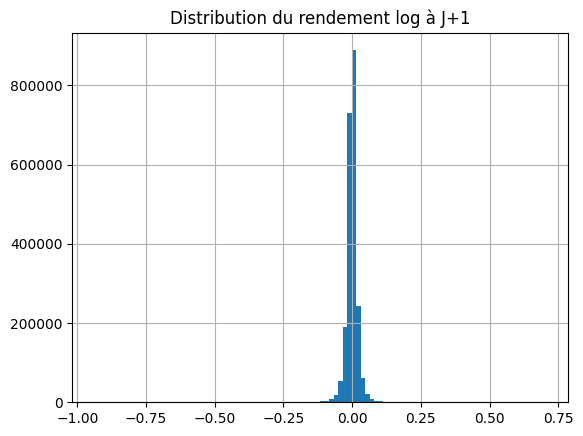

In [26]:
import matplotlib.pyplot as plt

df["target"].hist(bins=100)
plt.title("Distribution du rendement log à J+1")
plt.show()


<Axes: >

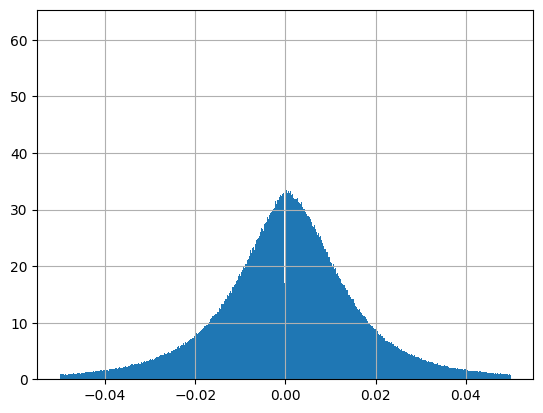

In [27]:
df['Return'].dropna().hist(bins=500, density=True, range=(-0.05, 0.05))

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def regression(df, features):

    # --- 8) Train/val/test split
    train = df[df["Date"] < "2018-01-01"]
    val   = df[(df["Date"] >= "2018-01-01") & (df["Date"] < "2021-01-01")]
    test  = df[df["Date"] >= "2021-01-01"].copy()   # copy important

    X_train, y_train = train[features], train["target"]
    X_val, y_val     = val[features], val["target"]
    X_test, y_test   = test[features], test["target"]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Prédictions sur le test
    y_pred = model.predict(X_test)

    # --- Autres métriques globales (régression)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    
    print("RMSE :", rmse)
    print("MAE  :", mae)
    print("R²   :", r2)
    
    test["pred"] = y_pred

    sector_rmse = (
        test.groupby("Sector")
            .apply(
                lambda g: np.sqrt(mean_squared_error(g["target"], g["pred"])),
                include_groups=False
            )
            .sort_values()
    )
    return  model, sector_rmse


In [30]:
regression(df, ["mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"])


RMSE : 0.02017081474380514
MAE  : 0.013757443556759324
R²   : -0.0007931475817530842


(LinearRegression(),
 Sector
 Utilities                 0.014979
 Consumer Staples          0.015601
 Real Estate               0.016513
 Industrials               0.018354
 Health Care               0.018926
 Financials                0.019698
 Materials                 0.020422
 Consumer Discretionary    0.022943
 Energy                    0.022999
 Communication Services    0.023258
 Information Technology    0.024569
 dtype: float64)

In [36]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


def xgb(df, features):

    # --- Train/val/test split temporel ---
    train = df[df["Date"] < "2018-01-01"]
    val   = df[(df["Date"] >= "2018-01-01") & (df["Date"] < "2021-01-01")]
    test  = df[df["Date"] >= "2021-01-01"].copy()

    X_train, y_train = train[features], train["target"]
    X_val,   y_val   = val[features],   val["target"]
    X_test,  y_test  = test[features],  test["target"]

    # --- Modèle XGBoost ---
    model = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=30,

    )

    # --- Entraînement ---
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # --- Prédiction ---
    y_pred = model.predict(X_test)

    # --- Métriques globales ---
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print("RMSE :", rmse)
    print("MAE  :", mae)
    print("R²   :", r2)

    # --- Prédiction stockée ---
    test["pred"] = y_pred

    # --- RMSE par secteur ---
    sector_rmse = (
        test.groupby("Sector")
            .apply(lambda g: np.sqrt(mean_squared_error(g["target"], g["pred"])),
                   include_groups=False)
            .sort_values()
    )

    return model, sector_rmse


In [39]:
xgb(df, ["Open", "Close", "High", "Low", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"])


RMSE : 0.020162785244076435
MAE  : 0.013754188997559097
R²   : 3.475556119680867e-06


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...),
 Sector
 Utilities                 0.014956
 Consumer Staples          0.015595
 Real Estate               0.016507
 Industrials               0.018350
 Health Care               0.018914
 Financials                0.019689
 Materials             